# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))

In [7]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)

In [8]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))/100).to_dict()
inventory_weights.pop('Total')

1.0

In [9]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [10]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

### Positions

In [11]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [12]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today()-datetime.timedelta(1),
                                        startdate=datetime.datetime(2024,5,5))
positions=positions.sort_index()
positions.index=pd.to_datetime(positions.index)

2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
LDUMAUSDT not retrieved


In [13]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [14]:
positions.to_excel('Positions.xlsx')

In [15]:
positions['Total']=positions.sum(axis=1)
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total']).fillna(0)

In [16]:
binance_data=Binance.get_price(positions.columns,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=np.log(1+binance_data.pct_change())

LDUMAUSDT not retrieved
Total not retrieved


In [17]:
historical_ptf=pd.DataFrame()

In [18]:
for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

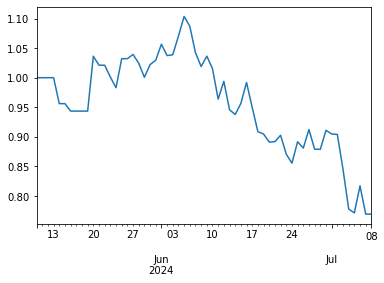

In [19]:
historical_ptf.dropna(axis = 0, how = 'all', inplace = True)
(1+historical_ptf['Historical Portfolio']).cumprod().plot()

### Ex ante data

In [20]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

In [21]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use)
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [22]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'EGLDUSDT', 'ENSUSDT',
       'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT',
       'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GNOUSDT', 'GRTUSDT',
       'HBARUSDT', 'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT',
       'LINKUSDT', 'LTCUSDT', 'MATICUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT',
       'NEXOUSDT', 'OMUSDT', 'OPUSDT', 'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT',
       'RNDRUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT',
       'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT',
       'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'XLMUSDT', 'XRPUSDT',
       'XTZUSDT'],
      dtype='object')

## Optimal Portfolio

In [23]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[12]-0.15},
                                                           {'type': 'ineq', 'fun': lambda weights: weights[20]-0.3}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
OMUSDT,0.411599
ETHUSDT,0.300000
BTCUSDT,0.150000
PEPEUSDT,0.079509
JASMYUSDT,0.058892


In [24]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[0]-0.3},
                                                           {'type': 'ineq', 'fun': lambda weights: weights[2]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
JASMYUSDT,0.55
BTCUSDT,0.30
ETHUSDT,0.15


## Real Portfolio vs Optimal

In [25]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current*100],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,600.839373,3.774408e+01,30.0,7.744083
JASMYUSDT,292.701593,1.838720e+01,55.0,-36.612801
ETHUSDT,207.454359,1.303206e+01,15.0,-1.967940
SOLUSDT,202.224838,1.270355e+01,0.0,0.000000
BBUSDT,138.728550,8.714778e+00,0.0,0.000000
MKRUSDT,98.477015,6.186220e+00,0.0,0.000000
BNBUSDT,51.366665,3.226799e+00,0.0,0.000000
TRXUSDT,0.047572,2.988453e-03,0.0,0.000000
FETUSDT,0.037035,2.326528e-03,0.0,0.000000
PEPEUSDT,0.000002,1.412672e-07,0.0,0.000000


In [26]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory*100],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,600.839373,3.774408e+01,15.0000,22.744083
JASMYUSDT,292.701593,1.838720e+01,5.8892,12.497999
ETHUSDT,207.454359,1.303206e+01,30.0000,-16.967940
SOLUSDT,202.224838,1.270355e+01,0.0000,0.000000
BBUSDT,138.728550,8.714778e+00,0.0000,0.000000
MKRUSDT,98.477015,6.186220e+00,0.0000,0.000000
BNBUSDT,51.366665,3.226799e+00,0.0000,0.000000
TRXUSDT,0.047572,2.988453e-03,0.0000,0.000000
FETUSDT,0.037035,2.326528e-03,0.0000,0.000000
PEPEUSDT,0.000002,1.412672e-07,7.9509,-7.950900


## Risk Reward Analysis

<AxesSubplot:>

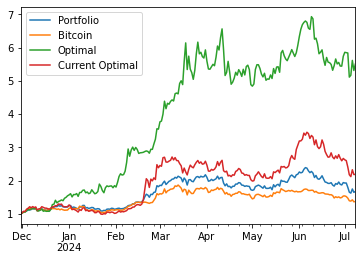

In [27]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf
(1+portfolio_perf).cumprod().plot()

In [28]:
portfolio_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

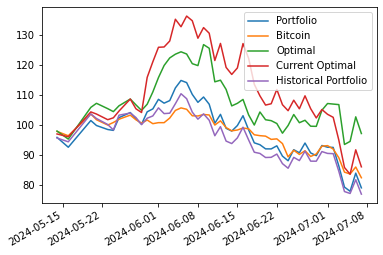

In [29]:
((1+portfolio_perf.loc[positions.index]).cumprod()*100).plot()

In [30]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.732009
dtype: float64

In [31]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio               0.501413
Bitcoin                 0.442026
Optimal                 0.733610
Current Optimal         0.750282
Historical Portfolio    0.500039
dtype: float64

In [32]:
perf_analysis=pd.concat([historical_risk.perf_contrib_pct(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.007745,0.025187,0.160888,0.040394,0.120494
ETHUSDT,0.012789,0.048004,0.325838,0.161576,0.164262
JASMYUSDT,0.013904,0.019420,0.036304,0.006227,0.030077
OMUSDT,0.933724,0.869706,0.412362,0.304146,0.108216
PEPEUSDT,0.031838,0.037683,0.064608,0.011349,0.053259


In [33]:
perf_analysis=pd.concat([current_risk.perf_contrib_pct(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.466926,0.370663,0.423896,0.202566,0.221331
JASMYUSDT,-0.166348,0.217201,0.161570,0.045451,0.116119
ETHUSDT,0.021620,0.141641,0.131656,0.023707,0.107949
SOLUSDT,0.154560,0.127362,0.131502,0.023707,0.107795
BBUSDT,0.332178,0.063988,0.068755,0.011363,0.057393
MKRUSDT,0.139459,0.051465,0.055116,0.005050,0.050066
BNBUSDT,0.051605,0.027679,0.027504,0.001263,0.026241


## Value At Risk

### Historical

In [34]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.060761524671010446, -0.08905971758415897)

In [35]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05865821154771759, -0.06924554192217693)

### Parametric

In [36]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07601379830364353, -0.09742867277401081)

In [37]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.06106634635969159, -0.0782701721234422)

### Multivariate

In [38]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06743456791401009, -0.08679425382813327)

In [39]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.060632401411507934, -0.07644465094847666)

### Copulas

In [40]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06616521462639015, -0.08603049042494541)

In [41]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06158749898866241, -0.07725313159153296)

In [42]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06695068694411424, -0.08511307527265424)

In [43]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06243784491990715, -0.07819652358940749)

### Monte Carlo

In [44]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07810016427062619, -0.09655658240635463)

In [45]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0628664204271238, -0.07876757745775992)

### VaR Violation

In [46]:
var_data=rolling_var(returns_to_use,opt_weights,window=15,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-30,-0.050305,-0.104601,-0.080236,0.019354
2023-12-31,-0.050305,-0.104401,-0.077059,0.030909
2024-01-01,-0.050305,-0.101728,-0.075776,0.017344
2024-01-02,-0.050305,-0.100543,-0.072541,0.023512
2024-01-03,-0.060216,-0.112796,-0.091326,-0.060951
...,...,...,...,...
2024-07-04,-0.111467,-0.094598,-0.102288,-0.124392
2024-07-05,-0.111467,-0.094357,-0.099101,0.010938
2024-07-06,-0.111467,-0.108958,-0.108004,0.086553
2024-07-07,-0.114552,-0.113942,-0.116684,-0.054103


In [47]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=5,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-18,-0.041467,-0.121764,-0.114291,0.011696
2024-05-19,-0.034009,-0.114504,-0.101933,-0.028280
2024-05-20,-0.034009,-0.122659,-0.109593,0.096028
2024-05-21,-0.027801,-0.113990,-0.094486,-0.016299
2024-05-22,-0.027801,-0.113905,-0.100543,0.001525
2024-05-23,-0.027801,-0.117199,-0.110123,-0.013322
2024-05-24,-0.016180,-0.109317,-0.096275,-0.003000
2024-05-25,-0.016180,-0.055750,-0.052518,0.043272
2024-05-26,-0.012909,-0.066356,-0.050492,0.048890
2024-05-27,-0.012909,-0.063880,-0.046681,0.016508


<AxesSubplot:>

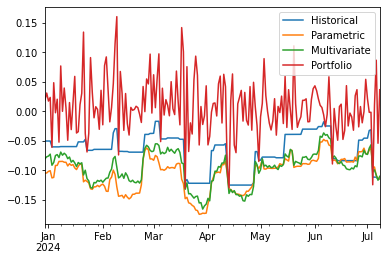

In [48]:
var_data.plot()

<AxesSubplot:>

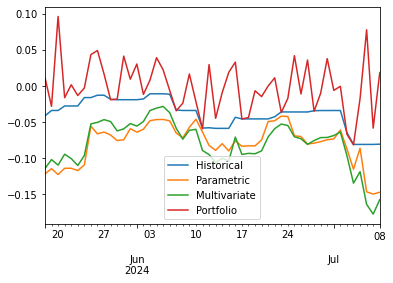

In [49]:
current_var_data.plot()

In [50]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.057292,0.010417,0.010417
Kupiec Stat,0.205681,9.237894,9.237894
P-value,0.650174,0.002371,0.002371


In [51]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.153846,0.0,0.0
Kupiec Stat,7.795932,5.334503,5.334503
P-value,0.005236,0.020907,0.020907


## Principal Component Analysis

In [52]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.75994525, 0.07549599, 0.06395879, 0.05579759, 0.04480239])

In [53]:
eigval,eigvec,portfolio_components=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.61223598, 0.16317231, 0.10066895, 0.08266472, 0.04125805])